In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs # train epochs for each update by a sequence of data
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs): # multiple epochs of updates on the same batch of data
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            # parts of the surrogate objective
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            surr = torch.min(surr1, surr2)
            # maximize the surrogate objective --> minimize its negative value
            actor_loss = torch.mean(-surr)
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_52513/2838917181.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s, episode=500, return=500.000]


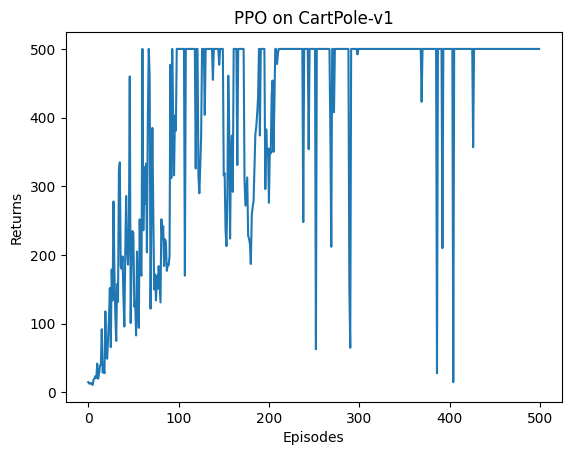

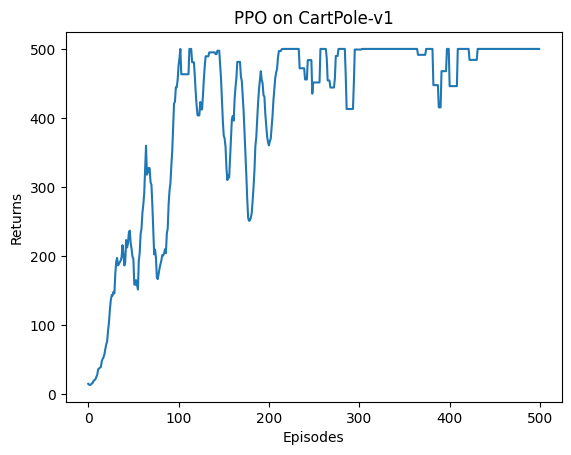

In [2]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.action_space.seed(0)
env.observation_space.seed(0)
np.random.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()